In [154]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from source_clustering import *
from utils import *
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Playground Notebook for the article :

## "Using Set Covering to Generate Databases for Holistic Steganalysis"

Through this notebook you will discover how to derive useful information from a PE matrix like we did for our experiments.

As a starting point, you can use the PE matrix we obtained following the protocol in the Section II of our article called ```CSM_Matrix_1.5bpp.txt``` .

The sources were built developing the 1115 RAW images in the file ```RAW_DATABASE.csv``` following the pipelines listed in ```pipelines.csv```.

### I - Let's play with the PE Matrix


To be able to use our methods, start to load your matrix with ```np.loadtxt``` and use it to initialize an object from the ```CSM``` class 


In [4]:
csm_study=CSM(np.loadtxt('../CSM_Matrix_1.5bpp.txt',delimiter=','))

The matrix provided will be load in the attribute ```csm_matrix``` of your instance.

You can for example reproduce our first table with the following command : 

In [136]:
csm_study.csm_matrix[[5,167],:][:,[5,167]]

array([[ 5.03, 77.38],
       [47.76,  0.18]])

You can also get access to the regret matrix pretty easily using the attribute ```regret_matrix``` of your current instance

In [128]:
csm_study.regret_matrix

array([[ 0.  , -0.81,  0.  , ..., 14.63, 15.26, 14.72],
       [ 1.35,  0.  ,  1.17, ..., 19.57, 21.91, 19.39],
       [ 0.18, -0.81,  0.  , ..., 15.26, 16.79, 15.26],
       ...,
       [13.37, 12.02, 13.28, ...,  0.  ,  2.52,  0.63],
       [15.89, 14.54, 15.08, ...,  0.53,  0.  ,  0.09],
       [13.64, 11.76, 13.19, ...,  0.44,  1.44,  0.  ]])

If you want to know the regret we got training on source $i$ and evaluating on source $j$, just call ```csm_study.regret_matrix[i,j]```.


In [155]:
csm_study.regret_matrix[5,167].round(2)

77.2

If you are crazy enough, you can also save the PE/Regret matrix we obtained as a .pdf heatmap using the method ```save_matrix```.

It will take some times so grab your coffee meanwhile.

Little advice, plot it ordering the rows and the columns according to the Intrinsic Difficulities of the sources.

In [158]:
csm_study.save_matrix(order=np.diag(csm_study.csm_matrix).argsort(),matrix_type='PE_matrix')

Our matrix could be very useful to understand the potential of some development pipelines compared to others. 

**Don't hesitate to use it to derive your own conclusions**

The function ```find_config``` can help you to get the ID of a source providing its parameters.


In [175]:
find_config(bayer_method='amaze',denoising=0,sharpen_micro=50,crop=512,ps_sharpening=3.0)

66

In [176]:
find_config(bayer_method='fast',denoising=50,sharpen_micro=0,crop=2048,ps_sharpening=3.0)

142

### II - Source Clustering/Covering 

Let's say now that you want to build a smart clustering of your sources using the PE matrix you just provided.

To do that, you can use our method ```greedy_covering``` and providing to it $\epsilon$, the maximum regret radius you can accept for your covering.

In [164]:
greedy_covering,current_representatives,current_labels=csm_study.greedy_covering(epsilon=10)

df=pd.DataFrame()
df['labels']=current_labels
df.value_counts()

Max max regrets :  9.97
Minimum number of sources for the optimal covering : 1.0


labels
229.0     159
60.0       69
21.0        9
31.0        4
22.0        2
dtype: int64

We reproduced here one result of the article. 

You can see that the greedy covering is able to spot 5 representatives 229,60,21,31,22 covering respectively 159,69,9,4,4,2 sources with a regret radius of at most 10%. 

Not so bad !

But wait, how do we get the pipelines parameters associated to these interesting representatives ?

You have the complete detail in the csv file ```pipelines.csv``` and you can simply use pandas to have your correspondance.

In [173]:
df=pd.read_csv('../pipelines.csv')
df.iloc[df.ID.values[list(greedy_covering.keys())]]

,ID,Demosaicking,Cropping,Denoising,SharpenMicro,Downsampling,PostResizeSharpening
229,229,fast,512,100,50,1.00,3.0
60,60,amaze,2048,0,0,0.25,3.0
21,21,amaze,512,0,100,1.00,0.0
31,31,fast,512,0,0,1.00,1.5
22,22,fast,512,0,100,1.00,0.0


This is nice but it does not enable to know precisely the content of each cluster found by the greedy covering.

That's why, we also provide you a function ```cluster_to_graph``` that enables to generate a graph representing the pipelines present in a cluster.

For instance, if we ask for the graph of the cluster represented by the source ```229```, we obtain :

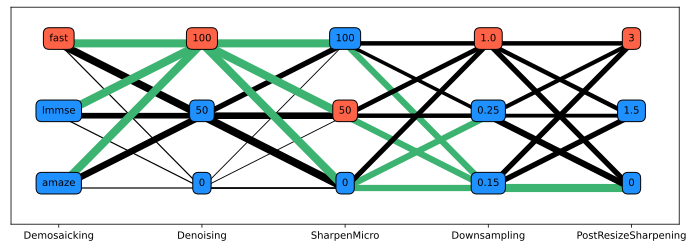

In [162]:
cluster_to_graph(229,current_labels)

In red, you have the parameters of the representative. Here it's ```229``` and you can check above that they are matching with the content of the table ```pipelines.csv```.

In green, you have the most represented links between all the pairs of links possible at each stage. For instance, among all the existing pairs (Demosaicking,Denoising), 3 of them are equally represented and preponderant in the cluster.

The more the lines are thick, the more the link associated is represented within the cluster.

In this specific cluster, we can observe that the majority of the sources involved are denoised with a significant denoising factor.

### III - Parameters importance

In the paper, we also proposed to assess the importance of the pipeline parameters in the CSM according to their discriminative power if we are using them to deduce the assignement of clusters.

This is done using a RandomForest algorithm taken as input a dataset with the pipeline parameters as features and the corresponding representatives as targets.

You can test it just like we did using the covering obtain with $\epsilon=1%$ and the function ```parameter_importance```

If you plot that graph with $\epsilon$ reasonably low (<10%), you will see that ```Denoising```,```DownSampling``` and ```PostResizeSharpening``` are the most discriminative parameters and hence, the most impactful for the CSM.


Max max regrets :  0.99
Minimum number of sources for the optimal covering : 7.0


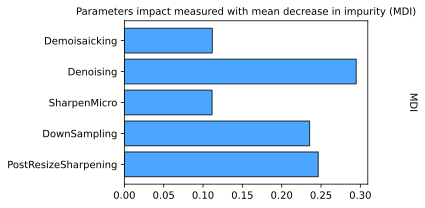

In [163]:
greedy_covering,current_representatives,current_labels=csm_study.greedy_covering(epsilon=1)
parameter_importance(current_labels)